# Signal preprocessing

## Libraries

In [ ]:
!pip install gwpy

In [ ]:
! pip install kaggle

In [3]:
from google.colab import files

In [ ]:
files.upload()

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
!kaggle competitions download -c g2net-gravitational-wave-detection

In [10]:
!mkdir tfm_g2n

In [ ]:
!unzip g2net-gravitational-wave-detection.zip -d tfm_g2n

In [ ]:
!pip install librosa

In [13]:
from gwpy.timeseries import TimeSeries # time domain data array in gwpy
from gwpy.plot import Plot # plotting in gwpy
from scipy.signal import hann
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d  # interpolating a 1-D function
import matplotlib.mlab as mlab  # some MATLAB commands
from glob import glob     # pathname management

import librosa
import librosa.display


#### Q-Transform
The constant quality factor transform (CQT), introduced by J.C. Brown in 1988, is an interesting alternative to the windowed Fourier transform (STFT / Short Time Fourier Transform) or wavelets, for time-frequency analysis.

The constant-Q transform transforms a data series to the frequency domain. It is related to the Fourier transform. In general, the transform is well suited to musical data and proves useful where frequencies span several octaves.It is more useful in the identification of instruments.

Unlike the Fourier transform, but similar to the mel scale, the constant-Q transform (Wikipedia) uses a logarithmically spaced frequency axis. The original paper reference below

Judith C. Brown, "Calculation of a constant Q spectral transform," J. Acoust. Soc. Am., 89(1):425–434, 1991.

From Wikipedia - In mathematics and signal processing, the constant-Q transform, simply known as CQT transforms a data series to the frequency domain. It is related to the Fourier transform[1] and very closely related to the complex Morlet wavelet transform. In general, the transform is well suited to musical data, and this can be seen in some of its advantages compared to the fast Fourier transform. As the output of the transform is effectively amplitude/phase against log frequency, fewer frequency bins are required to cover a given range effectively, and this proves useful where frequencies span several octaves. As the range of human hearing covers approximately ten octaves from 20 Hz to around 20 kHz, this reduction in output data is significant.

A Constant Q transform is a variation on the Discrete Fourier Transform (DFT). In other words, it is a type of wavelet transform.

I only have a casual understanding of both types of transforms myself, so take what I'm saying with a grain of salt.

A standard DFT uses a constant window size throughout all frequencies. This typically leads to a pretty consistent, fully continuous transform. However, the constant bin size for all frequencies leads to some problems when you map frequency on a logarithmic scale. Specifically, peaks on the lower end are incredibly wide (sometimes up to half an octave), lacking any sort of detail.

This is an issue for emulating human perception because humans perceive frequency on a logarithmic scale.

A Constant Q transform seeks to solve this problem by increasing the window size for lower frequencies, and alleviate some of the computational strain caused by this by reducing the window size used for high frequencies. It's pretty effective at this, but has a few drawbacks.

The computational complexity of a Constant Q transform is only slightly larger than that of a standard DFT, but because the window size changes per frequency, it is impossible to apply the typical optimizations of the FFT to a Constant Q transform.

In other words, a Constant Q transform will yield better results where low frequencies and logarithmic frequency mapping are concerned.

The transform exhibits a reduction in frequency resolution with higher frequency bins, which is desirable for auditory applications. The transform mirrors the human auditory system, whereby at lower-frequencies spectral resolution is better, whereas temporal resolution improves at higher frequencies.

CQT refers to a time-frequency representation where the frequency bins are geometrically spaced and the Q-factors (ratios of the center frequencies to bandwidths) of all bins are equal.

In [ ]:
!pip install --upgrade --force-reinstall --no-deps matplotlib

!pip install --force-reinstall --no-deps matplotlib==3.2.2

## Setup variables

In [ ]:
from google.colab import drive

In [ ]:
!ls "/content/tfm_g2n"

In [16]:
training_labels = pd.read_csv("/content/tfm_g2n/training_labels.csv")
training_labels.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [17]:
training_paths = glob("/content/tfm_g2n/train/*/*/*/*")
print("The total number of files in the training set:", len(training_paths))

The total number of files in the training set: 560000


In [18]:
ids = [path.split("/")[-1].split(".")[0] for path in training_paths]
paths_df = pd.DataFrame({"path":training_paths, "id": ids})
train_data = pd.merge(left=training_labels, right=paths_df, on="id")
train_data.head()

,id,target,path
0,00000e74ad,1,/content/tfm_g2n/train/0/0/0/00000e74ad.npy
1,00001f4945,0,/content/tfm_g2n/train/0/0/0/00001f4945.npy
2,0000661522,0,/content/tfm_g2n/train/0/0/0/0000661522.npy
3,00007a006a,0,/content/tfm_g2n/train/0/0/0/00007a006a.npy
4,0000a38978,1,/content/tfm_g2n/train/0/0/0/0000a38978.npy


In [19]:
sample_rate = 2048
signal_length = 2
NFFT = 4*sample_rate    # the Nyquist frequency -
f_min = 20.
f_max = sample_rate/2

## Signal preprocessing

##### Typical signal processing workflow
Next, we try to implement the steps from this paper referenced above by following these steps:

- Plot the raw signal
- Window the signal
- Whiten the signal
- Bandpass the signal

(0.0, 2.0)

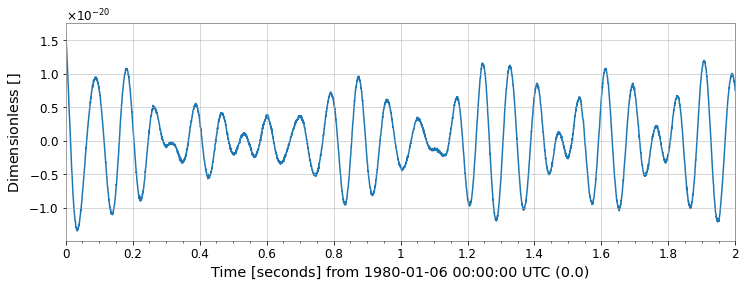

In [22]:
# Plot the raw signal
sample_gw_ts = TimeSeries(np.load(training_paths[0])[0], sample_rate=sample_rate)
plot = sample_gw_ts.plot()
ax = plot.gca()
ax.set_xlim(0, 2)

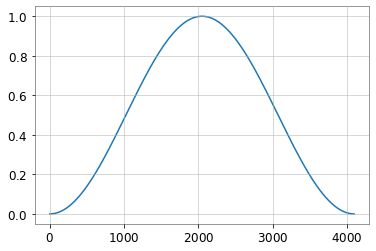

In [23]:
# get a window of lenght of the signal
hann_win = hann(sample_rate*signal_length, False)
plt.plot(hann_win)

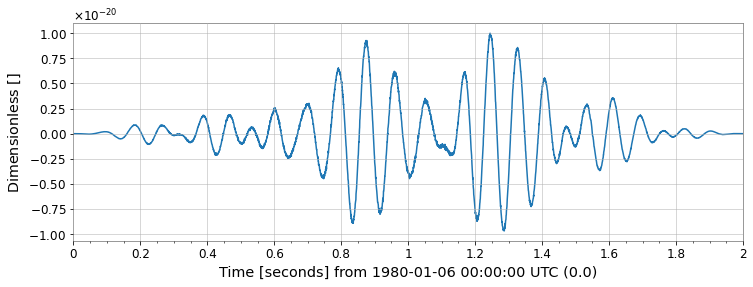

In [24]:
# plot the windowed signal
sample_gw_ts_win = sample_gw_ts * hann_win
plot = sample_gw_ts_win.plot()
ax = plot.gca()
ax.set_xlim(0, 2);

This is the windowed signal. Next, let's plot a whitened signal. As mentioned in the tutorial we referenced earlier, whitening the data is suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band. Whitening is always one of the first steps in astrophysical data analysis (searches, parameter estimation). Whitening requires no prior knowledge of spectral lines, etc; only the data are needed.

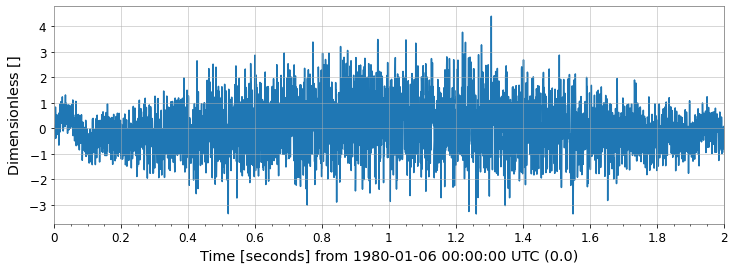

In [25]:
# plot the whitened signal
plot = sample_gw_ts.whiten().plot()
ax = plot.gca()
ax.set_xlim(0, 2);

This is the whitened signal. Next, since we know this data is from merger binary black holes, the frequency is in lower range and this we apply a bandpass filter to passthrough signals between 35 ~ 350 Hz.

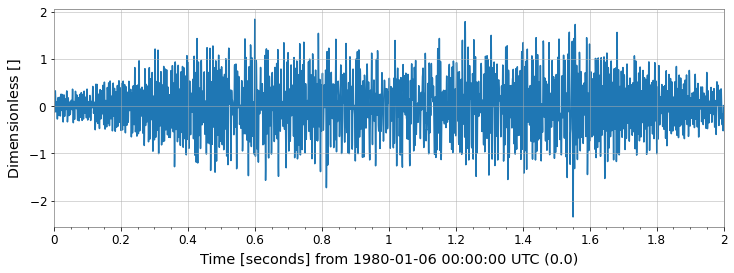

In [26]:
# Bandpass the above whitened data and plot
plot = sample_gw_ts.whiten().bandpass(35, 350).plot()
ax = plot.gca()
ax.set_xlim(0, 2);

### Signal Transformations - MFCC

In [27]:
def visualize_sample_mfcc(path,
                          df,
                          target,
                          sr=2048,
                          signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
):
    
    _id = df[df['target'] == target].sample(random_state=42)['id'].values[0]
    sample_id = df[df['target'] == target].sample(random_state=42).index[0]
    training_files = glob(path[sample_id])
    data = np.load(training_files[0])
    
    plt.figure(figsize=(16, 5))
    for i in range(3):
        mfccs = librosa.feature.mfcc(data[i] / data[i].max(), sr=sr)
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(mfccs, sr=sr, x_axis="time", vmin=-200, vmax=50, cmap="coolwarm")
        plt.title(signal_names[i], fontsize=14)
        plt.colorbar()

    plt.suptitle(f"Mel Frequency Cepstral Coefficients plots for sample: {_id}", fontsize=16)
    plt.show()


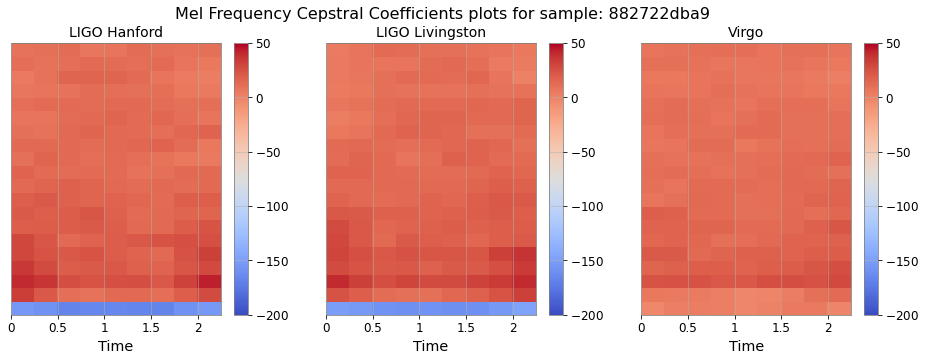

In [28]:
# plot the sample wit gravitational wave signal
visualize_sample_mfcc(training_paths,train_data,1)

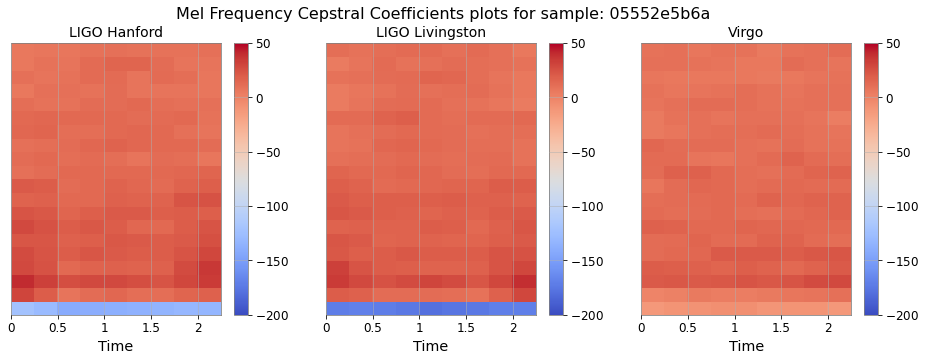

In [29]:
# plot the sample without gravitational wave signal
visualize_sample_mfcc(training_paths,train_data,0)

### Signal Transformations - Spectogram

In [73]:
def visualize_sample_spectogram(path,
    df, 
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
):

    # Get the data
    _id = df[df['target'] == target].sample(random_state=42)['id'].values[0]
    sample_id = df[df['target'] == target].sample(random_state=42).index[0]
    training_files = glob(path[sample_id])
    data = np.load(training_files[0])
    plt.figure(figsize=(16, 5))
    
    for i in range(3):
        X = librosa.stft(data[i] / data[i].max())
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(Xdb, sr=2048, x_axis="time", y_axis="hz", vmin=-30, vmax=50) 
        plt.colorbar()
        plt.title(signal_names[i], fontsize=14)

    plt.suptitle(f"Spectrogram plots for sample: {_id}, target:{target}", fontsize=16)
    plt.show()

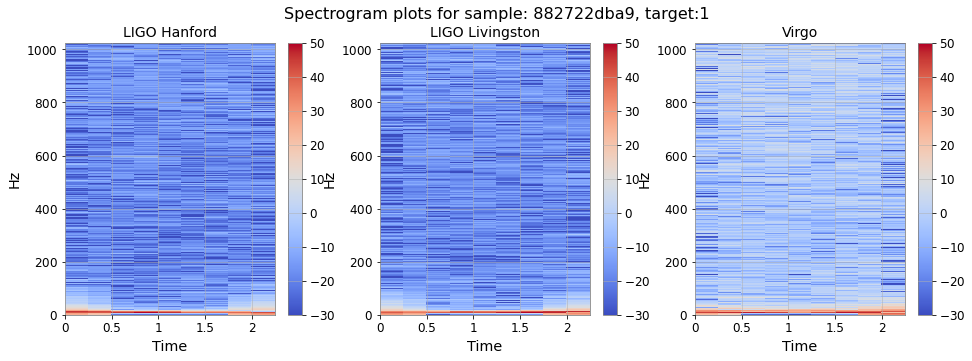

In [74]:
# plot the sample wit gravitational wave signal
visualize_sample_spectogram(training_paths,train_data,1)

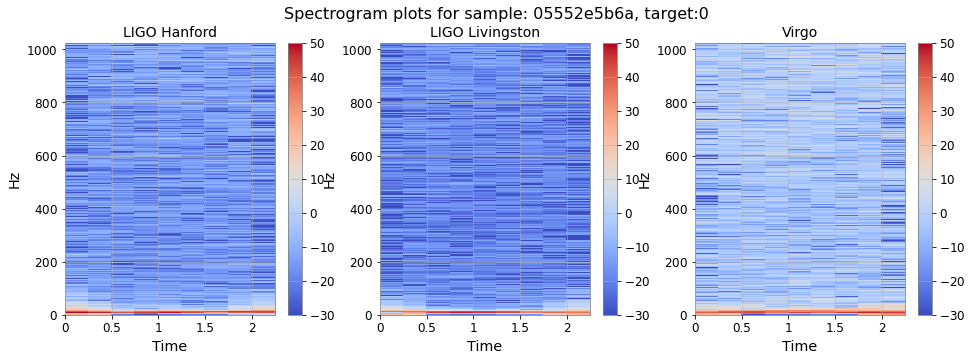

In [75]:
# plot the sample without gravitational wave signal
visualize_sample_spectogram(training_paths,train_data,0)

As seen in the image below, from the publication, our end signal looks very different to one the from the paper. 

To this end, let's see if we can get any info from the spectrogram images by tranforming the data using Constant Q-Transform.

### Signal Transformations - CQT

The signal analysis didn't provide much insights, so let's try the second method in signal processing. Tranforming the waves into spectrograms images, i.e. frequency-domain, and then visualize them. This technique is widely used in audio analysis (as shown here on this TensorFlow tutorial) and since our data is a wave with bunch of frequencies, we can use the same technique as well.

The advantage of using a spectrogram, over a direct Fourier Transform where you lose time info, is that it captures the shift or change in frequencies over time and this removes white noise frequencies that are persistent, leaving the signals of interest. Constant Q-Transform is one way to visualize the spectrogram.

In [35]:
# function to plot the Q-transform spectrogram side-by-side
def plot_q_transform_sbs(path,
                         df,
                        sample_rate,
                         signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
                        ):
    # Get the data
    _id_1 = df[df['target'] == 1].sample(random_state=42)['id'].values[0]
    sample_id_1 = df[df['target'] == 1].sample(random_state=42).index[0]
    training_files_1 = glob(path[sample_id_1])
    data_1 = np.load(training_files_1[0])

    _id_0 = df[df['target'] == 0].sample(random_state=42)['id'].values[0]
    sample_id_0 = df[df['target'] == 0].sample(random_state=42).index[0]
    training_files_0 = glob(path[sample_id_0])
    data_0 = np.load(training_files_0[0])
    
    for i in range(len(signal_names)):
        # get the timeseries
        ts_gw = TimeSeries(data_1[i], sample_rate=sample_rate)
        ts_no_gw = TimeSeries(data_0[i], sample_rate=sample_rate)
        
        # get the Q-transform
        image_gw = ts_gw.q_transform(whiten=True)
        image_no_gw = ts_no_gw.q_transform(whiten=True)

        plt.figure(figsize=(20, 10))
        plt.subplot(131)
        plt.imshow(image_gw)
        plt.title(f"id: {_id_1},{signal_names[i]} | Target=1")
        plt.grid(False)

        plt.subplot(132)
        plt.imshow(image_no_gw)
        plt.title(f"id: {_id_0},{signal_names[i]}  | Target=0")
        plt.grid(False)
        
        plt.show()
        

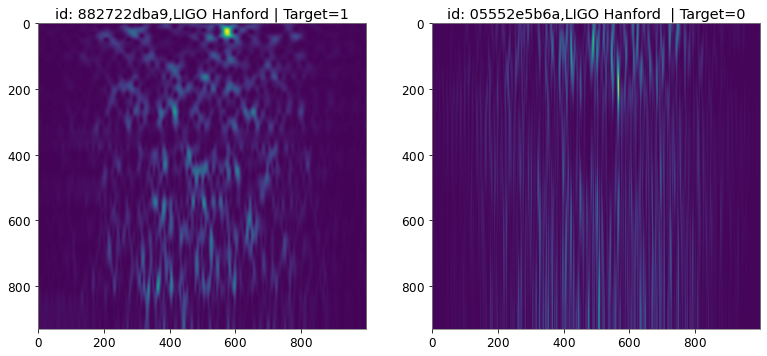

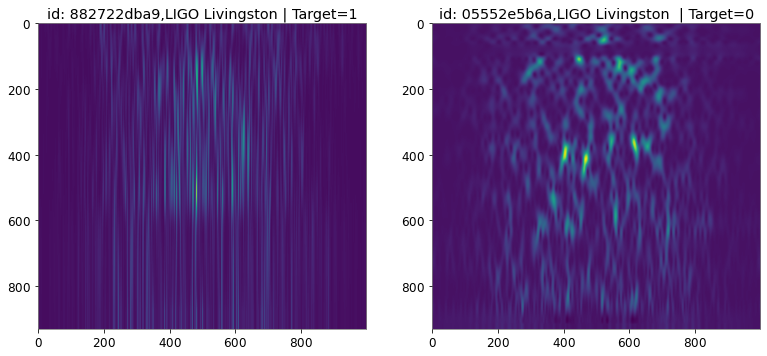

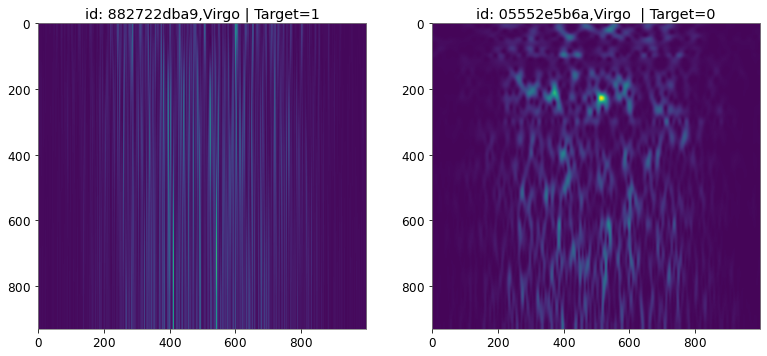

In [36]:
# let's plot two spectrograms for sample w/ and w/o GW signal side-by-side
plot_q_transform_sbs(training_paths,train_data,sample_rate)

Visibly, all three signals have different features and the above were plotted from a sample which has gravitational waves, and it shows the famous 'chirp' confirming the presence of gravitational waves. This transformation removes the unwanted noise frequencies, but still some of it remains, but a signal has to be detected in all three waves to be predicted as gravitational wave.

Next, we can compare how the Q-Transforms look for samples with and without gravitational wave signals.

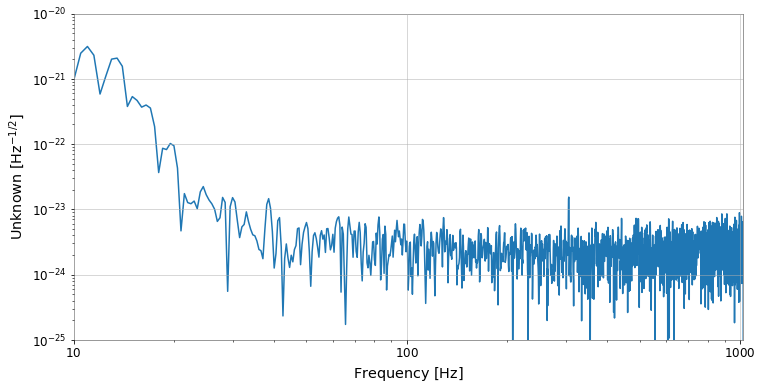

In [70]:
fig2 = sample_gw_ts_win.asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);